In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
from saltswap.swapper import Swapper

from openmmtools.integrators import GeodesicBAOABIntegrator
from saltswap.integrators import NCMCGeodesicBAOAB, NCMCMetpropolizedGeodesicBAOAB, GHMCIntegrator

In [2]:
print('OpenMM version: ', openmm.version.full_version)

OpenMM version:  7.2.0.dev-1f546d5


# Testing the protocol work evaluations for SaltSwap NCMC integrators

The test system will be a box of water

In [3]:
size = 20.0*unit.angstrom     # The length of the edges of the water box.
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
delta_chem = 317.0
wbox = WaterBox(box_edge=size, nonbondedMethod=app.PME, cutoff=9*unit.angstrom, ewaldErrorTolerance=1E-5)
wbox.system.addForce(openmm.MonteCarloBarostat(pressure, temperature))

# Number of equilibrium steps
nequil = 100
# Number of perturbation steps
npert = 50

## Compound integrator with GHMC performing NCMC
### Using the CPU platform

In [4]:
platform_name = 'CPU'

In [5]:
compound_integrator = openmm.CompoundIntegrator()
# The integrator to perform the equilibrium dynamics
compound_integrator.addIntegrator(GeodesicBAOABIntegrator(temperature=temperature, K_r=2, collision_rate=5.0 / unit.picosecond, timestep=2.0 * unit.femtosecond))
# The NCMC propagator
compound_integrator.addIntegrator(GHMCIntegrator(temperature=temperature, collision_rate=5.0 / unit.picosecond, timestep=1.0 * unit.femtosecond, nsteps=1))

# Creating the context
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(wbox.system, compound_integrator, platform)
context.setPositions(wbox.positions)

# Running some equilibriun dynamics
compound_integrator.setCurrentIntegrator(0)
compound_integrator.step(nequil)

# Creating the class to perform the `saltswap` moves.
salinator = Swapper(system=wbox.system, topology=wbox.topology, temperature=temperature, delta_chem=delta_chem,
                integrator=compound_integrator, pressure=pressure, npert=npert, nprop=1)

Getting the cumlative work at each step in the NCMC protocol for a number of repeats.

In [6]:
nrepeats = 100
internal_work = np.zeros((nrepeats, npert))
external_work = np.zeros((nrepeats, npert))
for i in range(nrepeats):
    in_wrk, ex_wrk = salinator.compare_protocol_work(context)
    compound_integrator.setCurrentIntegrator(0)
    compound_integrator.step(10)
    internal_work[i,:] = np.diff(in_wrk)
    external_work[i,:] = np.diff(ex_wrk)

Plotting the correlation between the two ways of mesuring the protocol work.

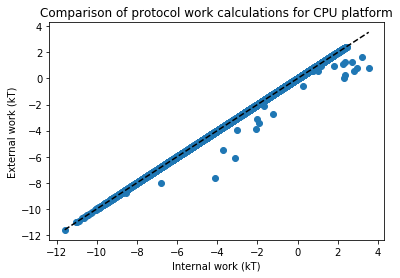

RMSD between work calculations = 0.12


In [7]:
x = y = np.linspace(internal_work.min(),internal_work.max())
plt.scatter(internal_work, external_work)
plt.plot(x,y, color='k', ls='--')
plt.title('Comparison of protocol work calculations for {0} platform'.format(platform_name))
plt.xlabel('Internal work (kT)')
plt.ylabel('External work (kT)')
plt.show()

print('RMSD between work calculations = {0:.2f}'.format(np.sqrt(((internal_work - external_work)**2).mean())))

Plotting the histogram of the differences between the two measuresments.

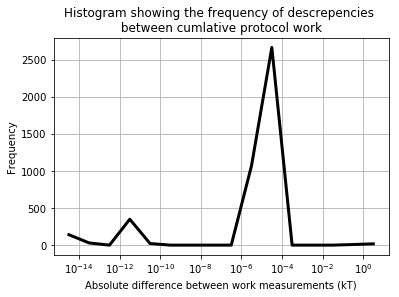

Fraction above 0.1 kT = 0.01


In [8]:
# Getting the absolute difference between the work calculations.
diffs = np.absolute(internal_work - external_work)

# Spacing the histogram on the log scale
log_edges = np.arange(-15,2)
log_midpoint = log_edges[:-1] + np.diff(log_edges) / 2.0
edges = 10.0**log_edges
midpoint = 10.0**log_midpoint 
hist, edges = np.histogram(diffs, bins=edges)

# Plotting the histogram on a log scale.
start_edge = edges[:-1]
plt.semilogx(midpoint, hist, color='k', lw=3)
plt.xlabel('Absolute difference between work measurements (kT)')
plt.ylabel('Frequency')
plt.title('Histogram showing the frequency of descrepencies \n between cumlative protocol work ')
plt.grid()
plt.show()

print('Fraction above 0.1 kT = {0:.2f}'.format(np.sum(diffs > 0.1) / diffs.size))

### Using the Reference platform

In [9]:
platform_name = 'Reference'

In [10]:
compound_integrator = openmm.CompoundIntegrator()
# The integrator to perform the equilibrium dynamics
compound_integrator.addIntegrator(GeodesicBAOABIntegrator(temperature=temperature, K_r=2, collision_rate=5.0 / unit.picosecond, timestep=2.0 * unit.femtosecond))
# The NCMC propagator
compound_integrator.addIntegrator(GHMCIntegrator(temperature=temperature, collision_rate=5.0 / unit.picosecond, timestep=1.0 * unit.femtosecond, nsteps=1))

# Creating the context
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(wbox.system, compound_integrator, platform)
context.setPositions(wbox.positions)

# Running some equilibriun dynamics
compound_integrator.setCurrentIntegrator(0)
compound_integrator.step(nequil)

# Creating the class to perform the `saltswap` moves.
salinator = Swapper(system=wbox.system, topology=wbox.topology, temperature=temperature, delta_chem=delta_chem,
                integrator=compound_integrator, pressure=pressure, npert=50, nprop=1)


Comparing the calculated protocol work for adding salt with `getState` and the internal calculation with the custom integrator.

In [12]:
nrepeats = 100
internal_work = np.zeros((nrepeats, npert))
external_work = np.zeros((nrepeats, npert))
for i in range(nrepeats):
    in_wrk, ex_wrk = salinator.compare_protocol_work(context)
    compound_integrator.setCurrentIntegrator(0)
    compound_integrator.step(10)
    internal_work[i,:] = np.diff(in_wrk)
    external_work[i,:] = np.diff(ex_wrk)

Plotting and getting the RMSD between the estimates:

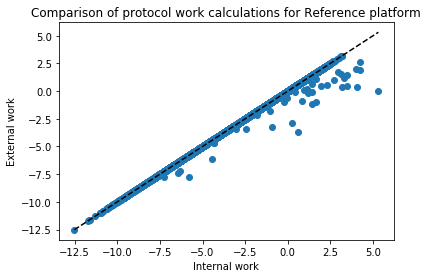

RMSD between work calculations = 0.18


In [13]:
x = y = np.linspace(internal_work.min(),internal_work.max())
plt.scatter(internal_work,external_work)
plt.plot(x,y, color='k', ls='--')
plt.title('Comparison of protocol work calculations for {0} platform'.format(platform_name))
plt.xlabel('Internal work')
plt.ylabel('External work')
plt.show()

print('RMSD between work calculations = {0:.2f}'.format(np.sqrt(((internal_work - external_work)**2).mean())))

Getting the histogram

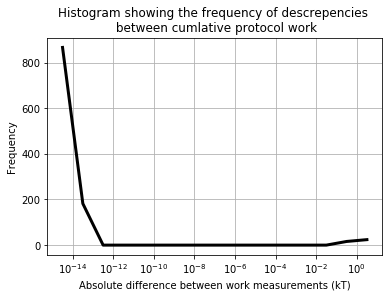

Fraction above 0.1 kT = 0.01


In [14]:
# Getting the absolute difference between the work calculations.
diffs = np.absolute(internal_work - external_work)

# Spacing the histogram on the log scale
log_edges = np.arange(-15,2)
log_midpoint = log_edges[:-1] + np.diff(log_edges) / 2.0
edges = 10.0**log_edges
midpoint = 10.0**log_midpoint 
hist, edges = np.histogram(diffs, bins=edges)

# Plotting the histogram on a log scale.
start_edge = edges[:-1]
plt.semilogx(midpoint, hist, color='k', lw=3)
plt.xlabel('Absolute difference between work measurements (kT)')
plt.ylabel('Frequency')
plt.title('Histogram showing the frequency of descrepencies \n between cumlative protocol work')
plt.grid()
plt.show()
print('Fraction above 0.1 kT = {0:.2f}'.format(np.sum(diffs > 0.1) / diffs.size))

## Compound integrator with gBAOAB performing NCMC

### Using the CPU platform

In [15]:
platform_name = 'CPU'

In [16]:
compound_integrator = openmm.CompoundIntegrator()
# The integrator to perform the equilibrium dynamics
compound_integrator.addIntegrator(GeodesicBAOABIntegrator(temperature=temperature, K_r=2, collision_rate=5.0 / unit.picosecond, timestep=2.0 * unit.femtosecond))
# The NCMC propagator
compound_integrator.addIntegrator(NCMCGeodesicBAOAB(temperature=temperature, collision_rate=5.0 / unit.picosecond, timestep=1.0 * unit.femtosecond))

# Creating the context
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(wbox.system, compound_integrator, platform)
context.setPositions(wbox.positions)

# Running some equilibriun dynamics
compound_integrator.setCurrentIntegrator(0)
compound_integrator.step(nequil)

# Creating the class to perform the `saltswap` moves.
salinator = Swapper(system=wbox.system, topology=wbox.topology, temperature=temperature, delta_chem=delta_chem,
                integrator=compound_integrator, pressure=pressure, npert=50, nprop=1)

Comparing the calculated protocol work for adding salt with `getState` and the internal calculation with the custom integrator.

In [17]:
nrepeats = 100
internal_work = np.zeros((nrepeats, npert))
external_work = np.zeros((nrepeats, npert))
for i in range(nrepeats):
    in_wrk, ex_wrk = salinator.compare_protocol_work(context)
    compound_integrator.setCurrentIntegrator(0)
    compound_integrator.step(10)
    internal_work[i,:] = np.diff(in_wrk)
    external_work[i,:] = np.diff(ex_wrk)

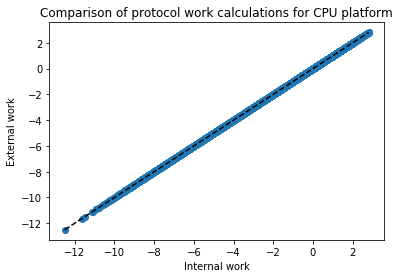

RMSD between work calculations = 0.00


In [18]:
x = y = np.linspace(internal_work.min(),internal_work.max())
plt.scatter(internal_work,external_work)
plt.plot(x,y, color='k', ls='--')
plt.title('Comparison of protocol work calculations for {0} platform'.format(platform_name))
plt.xlabel('Internal work')
plt.ylabel('External work')
plt.show()

print('RMSD between work calculations = {0:.2f}'.format(np.sqrt(((internal_work - external_work)**2).mean())))

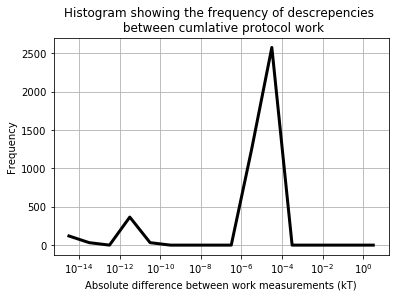

Fraction above 0.1 kT = 0.00


In [19]:
# Getting the absolute difference between the work calculations.
diffs = np.absolute(internal_work - external_work)

# Spacing the histogram on the log scale
log_edges = np.arange(-15,2)
log_midpoint = log_edges[:-1] + np.diff(log_edges) / 2.0
edges = 10.0**log_edges
midpoint = 10.0**log_midpoint 
hist, edges = np.histogram(diffs, bins=edges)

# Plotting the histogram on a log scale.
start_edge = edges[:-1]
plt.semilogx(midpoint, hist, color='k', lw=3)
plt.xlabel('Absolute difference between work measurements (kT)')
plt.ylabel('Frequency')
plt.title('Histogram showing the frequency of descrepencies \n between cumlative protocol work')
plt.grid()
plt.show()

print('Fraction above 0.1 kT = {0:.2f}'.format(np.sum(diffs > 0.1) / diffs.size))

### Using the Reference platform

In [ ]:
platform_name = 'Reference'

In [ ]:
compound_integrator = openmm.CompoundIntegrator()
# The integrator to perform the equilibrium dynamics
compound_integrator.addIntegrator(GeodesicBAOABIntegrator(temperature=temperature, K_r=2, collision_rate=5.0 / unit.picosecond, timestep=2.0 * unit.femtosecond))
# The NCMC propagator
compound_integrator.addIntegrator(NCMCGeodesicBAOAB(temperature=temperature, collision_rate=5.0 / unit.picosecond, timestep=1.0 * unit.femtosecond))

# Creating the context
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(wbox.system, compound_integrator, platform)
context.setPositions(wbox.positions)

# Running some equilibriun dynamics
compound_integrator.setCurrentIntegrator(0)
compound_integrator.step(nequil)

# Creating the class to perform the `saltswap` moves.
salinator = Swapper(system=wbox.system, topology=wbox.topology, temperature=temperature, delta_chem=delta_chem,
                integrator=compound_integrator, pressure=pressure, npert=50, nprop=1)

Comparing the calculated protocol work for adding salt with `getState` and the internal calculation with the custom integrator.

In [ ]:
nrepeats = 100
internal_work = np.zeros((nrepeats, npert))
external_work = np.zeros((nrepeats, npert))
for i in range(nrepeats):
    in_wrk, ex_wrk = salinator.test_ncmc(context)
    compound_integrator.setCurrentIntegrator(0)
    compound_integrator.step(10)
    internal_work[i,:] = np.diff(in_wrk)
    external_work[i,:] = np.diff(ex_wrk)

In [ ]:
x = y = np.linspace(internal_work.min(),internal_work.max())
plt.scatter(internal_work,external_work)
plt.plot(x,y, color='k', ls='--')
plt.title('Comparison of protocol work calculations for {0} platform'.format(platform_name))
plt.xlabel('Internal work')
plt.ylabel('External work')
plt.show()

print('RMSD between work calculations = {0:.2f}'.format(np.sqrt(((internal_work - external_work)**2).mean())))

And the histogram

In [ ]:
# Getting the absolute difference between the work calculations.
diffs = np.absolute(internal_work - external_work)

# Spacing the histogram on the log scale
log_edges = np.arange(-15,2)
log_midpoint = log_edges[:-1] + np.diff(log_edges) / 2.0
edges = 10.0**log_edges
midpoint = 10.0**log_midpoint 
hist, edges = np.histogram(diffs, bins=edges)

# Plotting the histogram on a log scale.
start_edge = edges[:-1]
plt.semilogx(midpoint, hist, color='k', lw=3)
plt.xlabel('Absolute difference between work measurements (kT)')
plt.ylabel('Frequency')
plt.title('Histogram showing the frequency of descrepencies \n between cumlative protocol work')
plt.grid()
plt.show()

### Viewing descrepancies as a function of step.

TODO

In [ ]:
plt.plot(np.mean(diffs, axis=0))
plt.xlabel('NCMC step')
plt.ylabel('Mean absolute difference')
plt.title('Mean absolute difference between work measurements \n as a function of NCMC step')
plt.show()